In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder

In [31]:
pd.set_option("display.max_columns" , None)
pd.set_option("display.max_rows" , 50)
plt.style.use('ggplot')


In [32]:
trainingDF_path = "train.csv"
DF_train = pd.read_csv(trainingDF_path)

testingDF_path = "test.csv"
DF_test = pd.read_csv(testingDF_path)

In [33]:
Numerical_DF_train = DF_train.select_dtypes(exclude='object')
Numerical_DF_test = DF_test.select_dtypes(exclude='object')

In [34]:
numerical_features = Numerical_DF_train.columns.drop('SalePrice')

# Iterate through each numerical feature
for feature in numerical_features:
    # Group by 'MSSubClass' and calculate the median within each group
    train_medians_by_mssc = Numerical_DF_train.groupby('MSSubClass')[feature].transform('median')
    test_medians_by_mssc = Numerical_DF_test.groupby('MSSubClass')[feature].transform('median')
    
    # Fill NaN values in the feature with the corresponding group median
    Numerical_DF_train[feature] = Numerical_DF_train[feature].fillna(train_medians_by_mssc) 
    Numerical_DF_test[feature] = Numerical_DF_test[feature].fillna(test_medians_by_mssc)
    
    train_medians_by_bldgtype = DF_train.groupby('BldgType')[feature].transform('median')
    test_medians_by_bldgtype = DF_test.groupby('BldgType')[feature].transform('median')
    
    # Fill NaN values in the feature with the corresponding group median
    Numerical_DF_train[feature] = DF_train[feature].fillna(train_medians_by_bldgtype)
    Numerical_DF_test[feature] = DF_test[feature].fillna(test_medians_by_bldgtype)

In [35]:

Numerical_DF_test.isna().sum().sort_values(ascending=False)

Id               0
FullBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
HalfBath         0
BsmtHalfBath     0
MSSubClass       0
BsmtFullBath     0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
YrSold           0
dtype: int64

In [36]:

Numerical_DF_train.isna().sum().sort_values(ascending=False)

Id               0
WoodDeckSF       0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
OpenPorchSF      0
MSSubClass       0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
HalfBath         0
FullBath         0
BsmtHalfBath     0
BsmtFullBath     0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
SalePrice        0
dtype: int64

# Feature filtering/transformation


In [37]:
Numerical_DF_train = Numerical_DF_train.drop(['Id'], axis = 1)
Numerical_DF_train = Numerical_DF_train.drop(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'], axis = 1)  # keep only the TotalBsmtSF
Numerical_DF_train = Numerical_DF_train.drop(['1stFlrSF', '2ndFlrSF','LowQualFinSF'], axis = 1) # keep only GrLivArea feature
Numerical_DF_train = Numerical_DF_train.drop(['BsmtFullBath', 'BsmtHalfBath', 'HalfBath'], axis = 1) # keep only the full number of rooms (kitche / bedrooms above Grade)
Numerical_DF_train = Numerical_DF_train.drop(['MoSold'], axis = 1) # keep only the year sold

# YearBuilt , "YearRemodAdd", 'GarageYrBlt', 'YrSold'  think to transform those into ages features
Numerical_DF_train['AgeSold'] = Numerical_DF_train['YrSold'] - \
                                Numerical_DF_train['YearBuilt']
              
              
Numerical_DF_train['Valueable_indice'] = (Numerical_DF_train['GrLivArea'] * 
                                         ((Numerical_DF_train['OverallCond'] + Numerical_DF_train['OverallQual']) / 2) ** 2) / \
                                         np.where(Numerical_DF_train['AgeSold'] == 0, 1, Numerical_DF_train['AgeSold'])
                                                           
# Calculate the difference between 'YearRemodAdd' and 'YearBuilt'
Numerical_DF_train['RemodBoolean'] = Numerical_DF_train['YearRemodAdd'] - Numerical_DF_train['YearBuilt']
Numerical_DF_train['RemodBoolean'] = Numerical_DF_train['RemodBoolean'].apply(lambda x: 0 if x == 0 else 1)

# Calculate the difference between 'YearRemodAdd' and 'YearBuilt'
Numerical_DF_train['GarageBuiltFromStart'] = Numerical_DF_train['GarageYrBlt'] - Numerical_DF_train['YearBuilt']
Numerical_DF_train['GarageBuiltFromStart'] = Numerical_DF_train['GarageBuiltFromStart'].apply(lambda x: 0 if x == 0 else 1)

# Create "PorchSF" by summing the porch columns
Numerical_DF_train['PorchSF'] = Numerical_DF_train['OpenPorchSF'] + \
                                 Numerical_DF_train['EnclosedPorch'] + \
                                 Numerical_DF_train['3SsnPorch'] + \
                                 Numerical_DF_train['ScreenPorch']

# 5. Drop the original edited columns
Numerical_DF_train = Numerical_DF_train.drop(['OpenPorchSF', 'EnclosedPorch', 
                                              '3SsnPorch', 'ScreenPorch',
                                              'YearRemodAdd' , 'YearBuilt', 'GarageYrBlt', 'YrSold' ], axis=1)

In [38]:
Numerical_DF_test = Numerical_DF_test.drop(['Id'], axis = 1)
Numerical_DF_test = Numerical_DF_test.drop(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'], axis = 1)  # keep only the TotalBsmtSF
Numerical_DF_test = Numerical_DF_test.drop(['1stFlrSF', '2ndFlrSF','LowQualFinSF'], axis = 1) # keep only GrLivArea feature
Numerical_DF_test = Numerical_DF_test.drop(['BsmtFullBath', 'BsmtHalfBath', 'HalfBath'], axis = 1) # keep only the full number of rooms (kitche / bedrooms above Grade)
Numerical_DF_test = Numerical_DF_test.drop(['MoSold'], axis = 1) # keep only the year sold

# YearBuilt , "YearRemodAdd", 'GarageYrBlt', 'YrSold'  think to transform those into ages features
Numerical_DF_test['AgeSold'] = Numerical_DF_test['YrSold'] - \
                                Numerical_DF_test['YearBuilt']
                                
Numerical_DF_test['Valueable_indice'] = (Numerical_DF_test['GrLivArea'] * 
                                         ((Numerical_DF_test['OverallCond'] + Numerical_DF_test['OverallQual']) / 2) ** 2) / \
                                         np.where(Numerical_DF_test['AgeSold'] == 0, 1, Numerical_DF_test['AgeSold'])
# Calculate the difference between 'YearRemodAdd' and 'YearBuilt'
Numerical_DF_test['RemodBoolean'] = Numerical_DF_test['YearRemodAdd'] - Numerical_DF_test['YearBuilt']
Numerical_DF_test['RemodBoolean'] = Numerical_DF_test['RemodBoolean'].apply(lambda x: 0 if x == 0 else 1)

# Calculate the difference between 'YearRemodAdd' and 'YearBuilt'
Numerical_DF_test['GarageBuiltFromStart'] = Numerical_DF_test['GarageYrBlt'] - Numerical_DF_test['YearBuilt']
Numerical_DF_test['GarageBuiltFromStart'] = Numerical_DF_test['GarageBuiltFromStart'].apply(lambda x: 0 if x == 0 else 1)

# Create "PorchSF" by summing the porch columns
Numerical_DF_test['PorchSF'] = Numerical_DF_test['OpenPorchSF'] + \
                                 Numerical_DF_test['EnclosedPorch'] + \
                                 Numerical_DF_test['3SsnPorch'] + \
                                 Numerical_DF_test['ScreenPorch']

# 5. Drop the original edited columns
Numerical_DF_test = Numerical_DF_test.drop(['OpenPorchSF', 'EnclosedPorch', 
                                              '3SsnPorch', 'ScreenPorch',
                                              'YearRemodAdd' , 'YearBuilt', 'GarageYrBlt', 'YrSold' ], axis=1)

In [39]:
Numerical_DF_test['AgeSold'].dtype

dtype('int64')

In [40]:
features_to_transform_withLog = ['LotFrontage', 'LotArea', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea', 'GarageArea','WoodDeckSF', 'PorchSF', 'PoolArea', 'MiscVal', 'Valueable_indice']
for feature in features_to_transform_withLog:
   Numerical_DF_train[feature] = Numerical_DF_train[feature].replace(0, 1)
   Numerical_DF_test[feature] = Numerical_DF_test[feature].replace(0, 1)
   
   Numerical_DF_train[feature] = np.log(Numerical_DF_train[feature])
   Numerical_DF_test[feature] = np.log(Numerical_DF_test[feature])

Numerical_DF_train['SalePrice'] = np.log(Numerical_DF_train['SalePrice'])

e:\ML Projects\Kaggle\House Prices\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Categorical features

In [41]:
Categorical_DF_train = DF_train.select_dtypes(include='object')
Categorical_DF_test = DF_test.select_dtypes(include='object')

# 1. Identify Columns with NaNs
nan_cols_train = Categorical_DF_train.columns[Categorical_DF_train.isna().any()].tolist()
nan_cols_test = Categorical_DF_test.columns[Categorical_DF_test.isna().any()].tolist()

# 2. Unite the Lists
all_nan_cols = list(set(nan_cols_train + nan_cols_test))  # Using set to avoid duplicates

# 3. Drop Columns
Categorical_DF_train = Categorical_DF_train.drop(all_nan_cols, axis=1)
Categorical_DF_test = Categorical_DF_test.drop(all_nan_cols, axis=1)

# Verification (optional)
print("Columns dropped from train:", nan_cols_train)
print("Columns dropped from test:", nan_cols_test)
print("Combined columns dropped:", all_nan_cols)


Columns dropped from train: ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Columns dropped from test: ['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']
Combined columns dropped: ['Electrical', 'BsmtQual', 'MasVnrType', 'MSZoning', 'GarageCond', 'GarageQual', 'BsmtExposure', 'KitchenQual', 'PoolQC', 'Utilities', 'GarageFinish', 'GarageType', 'Exterior1st', 'BsmtCond', 'BsmtFinType1', 'SaleType', 'Fence', 'Exterior2nd', 'FireplaceQu', 'BsmtFinType2', 'Functional', 'MiscFeature', 'Alley']


In [42]:
Numerical_DF_train = Numerical_DF_train.fillna(0)
Numerical_DF_test = Numerical_DF_test.fillna(0)

In [43]:
Numerical_DF_test.isna().sum().sort_values(ascending=False)

MSSubClass              0
Fireplaces              0
GarageBuiltFromStart    0
RemodBoolean            0
Valueable_indice        0
AgeSold                 0
MiscVal                 0
PoolArea                0
WoodDeckSF              0
GarageArea              0
GarageCars              0
TotRmsAbvGrd            0
LotFrontage             0
KitchenAbvGr            0
BedroomAbvGr            0
FullBath                0
GrLivArea               0
TotalBsmtSF             0
MasVnrArea              0
OverallCond             0
OverallQual             0
LotArea                 0
PorchSF                 0
dtype: int64

In [44]:
merged_df_train = pd.merge(Numerical_DF_train, Categorical_DF_train, left_index=True, right_index=True) 
merged_df_test = pd.merge(Numerical_DF_test,  Categorical_DF_test, left_index=True, right_index=True) 

In [45]:
# Identify categorical columns (adjust if you know them specifically)
categorical_cols = merged_df_train.select_dtypes(include=['object']).columns

# Initialize the TargetEncoder
encoder = TargetEncoder(cols=categorical_cols)

# Fit and transform the categorical columns directly in merged_df_train
merged_df_train[categorical_cols] = encoder.fit_transform(merged_df_train[categorical_cols], merged_df_train['SalePrice'])
merged_df_test[categorical_cols] = encoder.transform(merged_df_test[categorical_cols])

In [46]:
merged_df_test.isna().sum().sort_values(ascending=False)

MSSubClass              0
HouseStyle              0
LotShape                0
LandContour             0
LotConfig               0
LandSlope               0
Neighborhood            0
Condition1              0
Condition2              0
BldgType                0
RoofStyle               0
PorchSF                 0
RoofMatl                0
ExterQual               0
ExterCond               0
Foundation              0
Heating                 0
HeatingQC               0
CentralAir              0
PavedDrive              0
Street                  0
GarageBuiltFromStart    0
LotFrontage             0
KitchenAbvGr            0
LotArea                 0
OverallQual             0
OverallCond             0
MasVnrArea              0
TotalBsmtSF             0
GrLivArea               0
FullBath                0
BedroomAbvGr            0
TotRmsAbvGrd            0
RemodBoolean            0
Fireplaces              0
GarageCars              0
GarageArea              0
WoodDeckSF              0
PoolArea    

In [47]:
merged_df_train[['Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation',
       'Heating', 'HeatingQC', 'CentralAir', 'PavedDrive', 'SaleCondition', 'SalePrice']].corr()

,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,ExterQual,ExterCond,Foundation,Heating,HeatingQC,CentralAir,PavedDrive,SaleCondition,SalePrice
Street,1.000000,-0.005640,0.020130,0.014073,-0.168851,0.046847,-0.019963,-0.003361,0.095579,0.049985,-0.021593,0.006165,0.055296,-0.003309,0.047229,-0.008073,0.043100,0.069869,0.024756,0.011167,0.057369
LotShape,-0.005640,1.000000,0.115535,0.370876,0.107763,0.270144,0.093393,-0.066392,0.146755,0.117206,0.024202,0.063581,0.190940,0.055217,0.173181,0.056282,0.114800,0.114209,0.116115,0.045289,0.294869
LandContour,0.020130,0.115535,1.000000,0.088913,0.132368,0.154975,0.049162,-0.005696,0.051002,0.066582,0.042292,0.044820,0.114351,0.009614,0.125304,0.026911,0.069576,0.107397,0.112314,0.089603,0.159999
LotConfig,0.014073,0.370876,0.088913,1.000000,0.026954,0.099682,0.050589,0.000224,0.074293,0.035742,0.047098,0.016050,0.059695,0.022575,0.038727,0.028533,0.055963,0.057755,0.065294,-0.023461,0.151624
LandSlope,-0.168851,0.107763,0.132368,0.026954,1.000000,-0.005179,-0.006913,-0.017983,0.018264,-0.008173,0.009219,0.073996,-0.064588,-0.022137,-0.048299,-0.016229,-0.061581,-0.011334,-0.030361,-0.054090,0.035068
Neighborhood,0.046847,0.270144,0.154975,0.099682,-0.005179,1.000000,0.217756,0.086264,0.129252,0.348815,0.118224,0.025092,0.652542,0.187862,0.601063,0.112049,0.435613,0.271808,0.298551,0.323810,0.740920
Condition1,-0.019963,0.093393,0.049162,0.050589,-0.006913,0.217756,1.000000,0.090119,0.076764,0.151487,0.029642,-0.016484,0.165312,0.100680,0.170970,0.068983,0.121090,0.065209,0.165470,0.073563,0.196337
Condition2,-0.003361,-0.066392,-0.005696,0.000224,-0.017983,0.086264,0.090119,1.000000,0.034351,0.006613,0.042181,0.005022,0.112845,0.053728,0.072888,-0.006576,0.065067,0.077555,0.020951,0.069508,0.107957
BldgType,0.095579,0.146755,0.051002,0.074293,0.018264,0.129252,0.076764,0.034351,1.000000,-0.025064,0.061906,0.028816,0.155238,0.079923,0.145903,0.065669,0.176753,0.187572,0.095341,0.088802,0.199399
HouseStyle,0.049985,0.117206,0.066582,0.035742,-0.008173,0.348815,0.151487,0.006613,-0.025064,1.000000,0.004867,0.001980,0.258517,0.112695,0.325319,0.104255,0.174782,0.055277,0.097710,0.097351,0.310850


In [48]:
merged_df_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,TotalBsmtSF,GrLivArea,FullBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,PoolArea,MiscVal,SalePrice,AgeSold,Valueable_indice,RemodBoolean,GarageBuiltFromStart,PorchSF,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,ExterQual,ExterCond,Foundation,Heating,HeatingQC,CentralAir,PavedDrive,SaleCondition
0,60,4.174387,9.041922,7,5,5.278115,6.752270,7.444249,2,3,1,8,0,2,6.306275,0.000000,0.0,0.000000,12.247694,5,9.418330,0,0,4.110874,12.025522,11.936094,12.022694,12.001900,12.020565,12.163641,12.042916,12.025895,12.047512,12.182686,11.98420,12.019216,12.311282,12.043078,12.261665,12.032078,12.207626,12.06109,12.059895,12.005034
1,20,4.382027,9.169518,6,8,0.000000,7.140453,7.140453,2,3,1,6,1,2,6.131226,5.697093,0.0,0.000000,12.109011,31,7.598286,0,0,0.000000,12.025522,11.936094,12.022694,12.034068,12.020565,12.116583,11.818794,12.025895,12.047512,11.993683,11.98420,12.019216,11.837985,12.043078,11.870080,12.032078,12.207626,12.06109,12.059895,12.005034
2,60,4.219508,9.328123,7,5,5.087596,6.824374,7.487734,2,3,1,6,1,2,6.410175,0.000000,0.0,0.000000,12.317167,7,9.125343,1,0,3.737670,12.025522,12.163465,12.022694,12.001900,12.020565,12.163641,12.042916,12.025895,12.047512,12.182686,11.98420,12.019216,12.311282,12.043078,12.261665,12.032078,12.207626,12.06109,12.059895,12.005034
3,70,4.094345,9.164296,7,5,0.000000,6.628041,7.448334,1,3,1,7,1,3,6.464588,0.000000,0.0,0.000000,11.849398,91,6.520993,1,1,5.726848,12.025522,12.163465,12.022694,12.027446,12.020565,12.198787,12.042916,12.025895,12.047512,12.182686,11.98420,12.019216,11.837985,12.043078,11.722529,12.032078,11.910371,12.06109,12.059895,11.788846
4,60,4.430817,9.565214,8,5,5.857933,7.043160,7.695303,2,4,1,9,1,3,6.728629,5.257495,0.0,0.000000,12.429216,8,9.359466,0,0,4.430817,12.025522,12.163465,12.022694,12.034068,12.020565,12.604875,12.042916,12.025895,12.047512,12.182686,11.98420,12.019216,12.311282,12.043078,12.261665,12.032078,12.207626,12.06109,12.059895,12.005034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,4.127134,8.976768,6,5,0.000000,6.859615,7.406711,2,3,1,7,1,2,6.131226,0.000000,0.0,0.000000,12.072541,8,8.736765,1,0,3.688879,12.025522,11.936094,12.022694,12.001900,12.020565,12.155443,12.042916,12.025895,12.047512,12.182686,11.98420,12.019216,11.837985,12.043078,12.261665,12.032078,12.207626,12.06109,12.059895,12.005034
1456,20,4.442651,9.486076,6,6,4.779123,7.340836,7.636752,2,3,1,7,2,2,6.214608,5.855072,0.0,0.000000,12.254863,32,7.754535,1,0,0.000000,12.025522,11.936094,12.022694,12.001900,12.020565,12.130080,12.042916,12.025895,12.047512,11.993683,11.98420,12.019216,11.837985,12.043078,11.870080,12.032078,11.816065,12.06109,12.059895,12.005034
1457,70,4.189655,9.109636,7,9,0.000000,7.049255,7.757906,2,4,1,9,2,1,5.529429,0.000000,0.0,7.824046,12.493130,69,7.682683,1,0,4.094345,12.025522,11.936094,12.022694,12.001900,12.020565,12.198787,12.042916,12.025895,12.047512,12.182686,11.98420,12.019216,12.735062,11.969451,12.006070,12.032078,12.207626,12.06109,12.059895,12.005034
1458,20,4.219508,9.181632,5,6,0.000000,6.982863,6.982863,1,2,1,5,0,1,5.480639,5.902633,0.0,0.000000,11.864462,60,6.298014,1,0,4.718499,12.025522,11.936094,12.022694,12.001900,12.020565,11.868045,12.042916,12.025895,12.047512,11.993683,12.18443,12.019216,11.837985,12.043078,11.870080,12.032078,11.910371,12.06109,12.059895,12.005034


In [49]:
# correlation_matrix = merged_df_train.corr() 

# saleprice_correlations = correlation_matrix['SalePrice'] 
# features_to_drop = saleprice_correlations[abs(saleprice_correlations) < 0.2].index
# merged_df_train = merged_df_train.drop(features_to_drop, axis=1) 
# merged_df_test = merged_df_test.drop(features_to_drop, axis=1) 

In [50]:
merged_df_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,TotalBsmtSF,GrLivArea,FullBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,PoolArea,MiscVal,SalePrice,AgeSold,Valueable_indice,RemodBoolean,GarageBuiltFromStart,PorchSF,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,ExterQual,ExterCond,Foundation,Heating,HeatingQC,CentralAir,PavedDrive,SaleCondition
0,60,4.174387,9.041922,7,5,5.278115,6.752270,7.444249,2,3,1,8,0,2,6.306275,0.000000,0.0,0.000000,12.247694,5,9.418330,0,0,4.110874,12.025522,11.936094,12.022694,12.001900,12.020565,12.163641,12.042916,12.025895,12.047512,12.182686,11.98420,12.019216,12.311282,12.043078,12.261665,12.032078,12.207626,12.06109,12.059895,12.005034
1,20,4.382027,9.169518,6,8,0.000000,7.140453,7.140453,2,3,1,6,1,2,6.131226,5.697093,0.0,0.000000,12.109011,31,7.598286,0,0,0.000000,12.025522,11.936094,12.022694,12.034068,12.020565,12.116583,11.818794,12.025895,12.047512,11.993683,11.98420,12.019216,11.837985,12.043078,11.870080,12.032078,12.207626,12.06109,12.059895,12.005034
2,60,4.219508,9.328123,7,5,5.087596,6.824374,7.487734,2,3,1,6,1,2,6.410175,0.000000,0.0,0.000000,12.317167,7,9.125343,1,0,3.737670,12.025522,12.163465,12.022694,12.001900,12.020565,12.163641,12.042916,12.025895,12.047512,12.182686,11.98420,12.019216,12.311282,12.043078,12.261665,12.032078,12.207626,12.06109,12.059895,12.005034
3,70,4.094345,9.164296,7,5,0.000000,6.628041,7.448334,1,3,1,7,1,3,6.464588,0.000000,0.0,0.000000,11.849398,91,6.520993,1,1,5.726848,12.025522,12.163465,12.022694,12.027446,12.020565,12.198787,12.042916,12.025895,12.047512,12.182686,11.98420,12.019216,11.837985,12.043078,11.722529,12.032078,11.910371,12.06109,12.059895,11.788846
4,60,4.430817,9.565214,8,5,5.857933,7.043160,7.695303,2,4,1,9,1,3,6.728629,5.257495,0.0,0.000000,12.429216,8,9.359466,0,0,4.430817,12.025522,12.163465,12.022694,12.034068,12.020565,12.604875,12.042916,12.025895,12.047512,12.182686,11.98420,12.019216,12.311282,12.043078,12.261665,12.032078,12.207626,12.06109,12.059895,12.005034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,4.127134,8.976768,6,5,0.000000,6.859615,7.406711,2,3,1,7,1,2,6.131226,0.000000,0.0,0.000000,12.072541,8,8.736765,1,0,3.688879,12.025522,11.936094,12.022694,12.001900,12.020565,12.155443,12.042916,12.025895,12.047512,12.182686,11.98420,12.019216,11.837985,12.043078,12.261665,12.032078,12.207626,12.06109,12.059895,12.005034
1456,20,4.442651,9.486076,6,6,4.779123,7.340836,7.636752,2,3,1,7,2,2,6.214608,5.855072,0.0,0.000000,12.254863,32,7.754535,1,0,0.000000,12.025522,11.936094,12.022694,12.001900,12.020565,12.130080,12.042916,12.025895,12.047512,11.993683,11.98420,12.019216,11.837985,12.043078,11.870080,12.032078,11.816065,12.06109,12.059895,12.005034
1457,70,4.189655,9.109636,7,9,0.000000,7.049255,7.757906,2,4,1,9,2,1,5.529429,0.000000,0.0,7.824046,12.493130,69,7.682683,1,0,4.094345,12.025522,11.936094,12.022694,12.001900,12.020565,12.198787,12.042916,12.025895,12.047512,12.182686,11.98420,12.019216,12.735062,11.969451,12.006070,12.032078,12.207626,12.06109,12.059895,12.005034
1458,20,4.219508,9.181632,5,6,0.000000,6.982863,6.982863,1,2,1,5,0,1,5.480639,5.902633,0.0,0.000000,11.864462,60,6.298014,1,0,4.718499,12.025522,11.936094,12.022694,12.001900,12.020565,11.868045,12.042916,12.025895,12.047512,11.993683,12.18443,12.019216,11.837985,12.043078,11.870080,12.032078,11.910371,12.06109,12.059895,12.005034


In [51]:
# chosen_features = [ 'LotFrontage', 
#                    'OverallQual', 
#                     'OverallCond',
#                    'GrLivArea', 
#                    #'FullBath', 
#                    # 'BedroomAbvGr', 
#                    # 'KitchenAbvGr', 
#                    # 'TotRmsAbvGrd', 
#                    'Fireplaces', 
#                     'GarageCars', 
#                    # 'WoodDeckSF', 
#                    # 'PoolArea', 
#                    # 'MiscVal',  
#                   'AgeSold', 
#                   'RemodBoolean', 
#                    'GarageBuiltFromStart', 
#                   # 'PorchSF' , 
#                   'SalePrice']
# Numerical_DF_train = Numerical_DF_train[chosen_features]
# Numerical_DF_test = Numerical_DF_test[chosen_features[:-1]]

In [52]:
X = merged_df_train.drop('SalePrice', axis = 1)
y = merged_df_train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

# Global overview of popular regression models

In [53]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
import numpy as np



def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Trains a model, makes predictions, and calculates RMSE for training and testing sets.
    """
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print(f"Model: {type(model).__name__}")
    print(f"Train RMSE: {train_rmse}")
    print(f"Test RMSE: {test_rmse}")
    print("-" * 20)
    return train_rmse, test_rmse

# 1. Linear Regression
linear_model = LinearRegression()
evaluate_model(linear_model, X_train, y_train, X_test, y_test)

# 2. Ridge Regression
ridge_model = Ridge(alpha=1.0)
evaluate_model(ridge_model, X_train, y_train, X_test, y_test)

# 3. Lasso Regression
lasso_model = Lasso(alpha=1.0)
evaluate_model(lasso_model, X_train, y_train, X_test, y_test)

# 8. XGBoost
xgb_reg = xgb.XGBRegressor()
evaluate_model(xgb_reg, X_train, y_train, X_test, y_test)

# 4. Elastic Net Regression
elastic_net_model = ElasticNet(alpha=1.0, l1_ratio=0.5)
evaluate_model(elastic_net_model, X_train, y_train, X_test, y_test)

# 5. Support Vector Regression (SVR)
svr_model = SVR(kernel='rbf')
evaluate_model(svr_model, X_train, y_train, X_test, y_test)

# 6. Decision Tree Regressor
dt_model = DecisionTreeRegressor(max_depth=5)
evaluate_model(dt_model, X_train, y_train, X_test, y_test)

# 7. Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100)
evaluate_model(rf_model, X_train, y_train, X_test, y_test)



# 9. LightGBM
lgb_model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=100)
evaluate_model(lgb_model, X_train, y_train, X_test, y_test)



Model: LinearRegression
Train RMSE: 0.12033410825632386
Test RMSE: 0.1498147284422821
--------------------
Model: Ridge
Train RMSE: 0.12143112021200998
Test RMSE: 0.1497398841365474
--------------------
Model: Lasso
Train RMSE: 0.32149652558334624
Test RMSE: 0.3339741409819887
--------------------
Model: XGBRegressor
Train RMSE: 0.004231295599448057
Test RMSE: 0.1603455362639194
--------------------
Model: ElasticNet
Train RMSE: 0.31947823079553
Test RMSE: 0.3301653637726638
--------------------
Model: SVR
Train RMSE: 0.1816783676533161
Test RMSE: 0.20493942885661195
--------------------
Model: DecisionTreeRegressor
Train RMSE: 0.13785631797349285
Test RMSE: 0.19606669317229014
--------------------
Model: RandomForestRegressor
Train RMSE: 0.052838566667160476
Test RMSE: 0.143950840548742
--------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] 

(0.0686323292121794, 0.14096653729999592)

# XGBOOST Regression



In [54]:
reg = xgb.XGBRegressor(base_score=0, 
                       booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=2,
                       learning_rate=0.03,
                       reg_alpha = 0,
                       reg_lambda = 0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=10)

[0]	validation_0-rmse:11.68188	validation_1-rmse:11.65145
[10]	validation_0-rmse:8.61584	validation_1-rmse:8.58925
[20]	validation_0-rmse:6.35507	validation_1-rmse:6.33217
[30]	validation_0-rmse:4.68811	validation_1-rmse:4.66745
[40]	validation_0-rmse:3.45912	validation_1-rmse:3.44105
[50]	validation_0-rmse:2.55317	validation_1-rmse:2.53721
[60]	validation_0-rmse:1.88556	validation_1-rmse:1.87121
[70]	validation_0-rmse:1.39388	validation_1-rmse:1.38114
[80]	validation_0-rmse:1.03212	validation_1-rmse:1.02123
[90]	validation_0-rmse:0.76643	validation_1-rmse:0.75757
[100]	validation_0-rmse:0.57189	validation_1-rmse:0.56568
[110]	validation_0-rmse:0.43016	validation_1-rmse:0.42735
[120]	validation_0-rmse:0.32780	validation_1-rmse:0.32901
[130]	validation_0-rmse:0.25478	validation_1-rmse:0.26077
[140]	validation_0-rmse:0.20368	validation_1-rmse:0.21504
[150]	validation_0-rmse:0.16886	validation_1-rmse:0.18544
[160]	validation_0-rmse:0.14574	validation_1-rmse:0.16740
[170]	validation_0-rmse

e:\ML Projects\Kaggle\House Prices\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:15:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[250]	validation_0-rmse:0.10138	validation_1-rmse:0.14041
[260]	validation_0-rmse:0.10034	validation_1-rmse:0.13983
[270]	validation_0-rmse:0.09945	validation_1-rmse:0.13928
[280]	validation_0-rmse:0.09860	validation_1-rmse:0.13881
[290]	validation_0-rmse:0.09792	validation_1-rmse:0.13849
[300]	validation_0-rmse:0.09729	validation_1-rmse:0.13820
[310]	validation_0-rmse:0.09666	validation_1-rmse:0.13792
[320]	validation_0-rmse:0.09614	validation_1-rmse:0.13767
[330]	validation_0-rmse:0.09554	validation_1-rmse:0.13734
[340]	validation_0-rmse:0.09496	validation_1-rmse:0.13724
[350]	validation_0-rmse:0.09454	validation_1-rmse:0.13712
[360]	validation_0-rmse:0.09403	validation_1-rmse:0.13696
[370]	validation_0-rmse:0.09357	validation_1-rmse:0.13677
[380]	validation_0-rmse:0.09319	validation_1-rmse:0.13660
[390]	validation_0-rmse:0.09270	validation_1-rmse:0.13640
[400]	validation_0-rmse:0.09233	validation_1-rmse:0.13631
[410]	validation_0-rmse:0.09187	validation_1-rmse:0.13618
[420]	validati

XGBRegressor(base_score=0, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [55]:
reg = xgb.XGBRegressor(base_score=0, 
                       booster='gbtree',    
                       n_estimators=1000,
                       
                       objective='reg:linear',
                       max_depth=2,
                       learning_rate=0.03,
                       reg_alpha = 0,
                       reg_lambda = 0.01)

reg.fit(X, y)

e:\ML Projects\Kaggle\House Prices\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:15:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=0, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

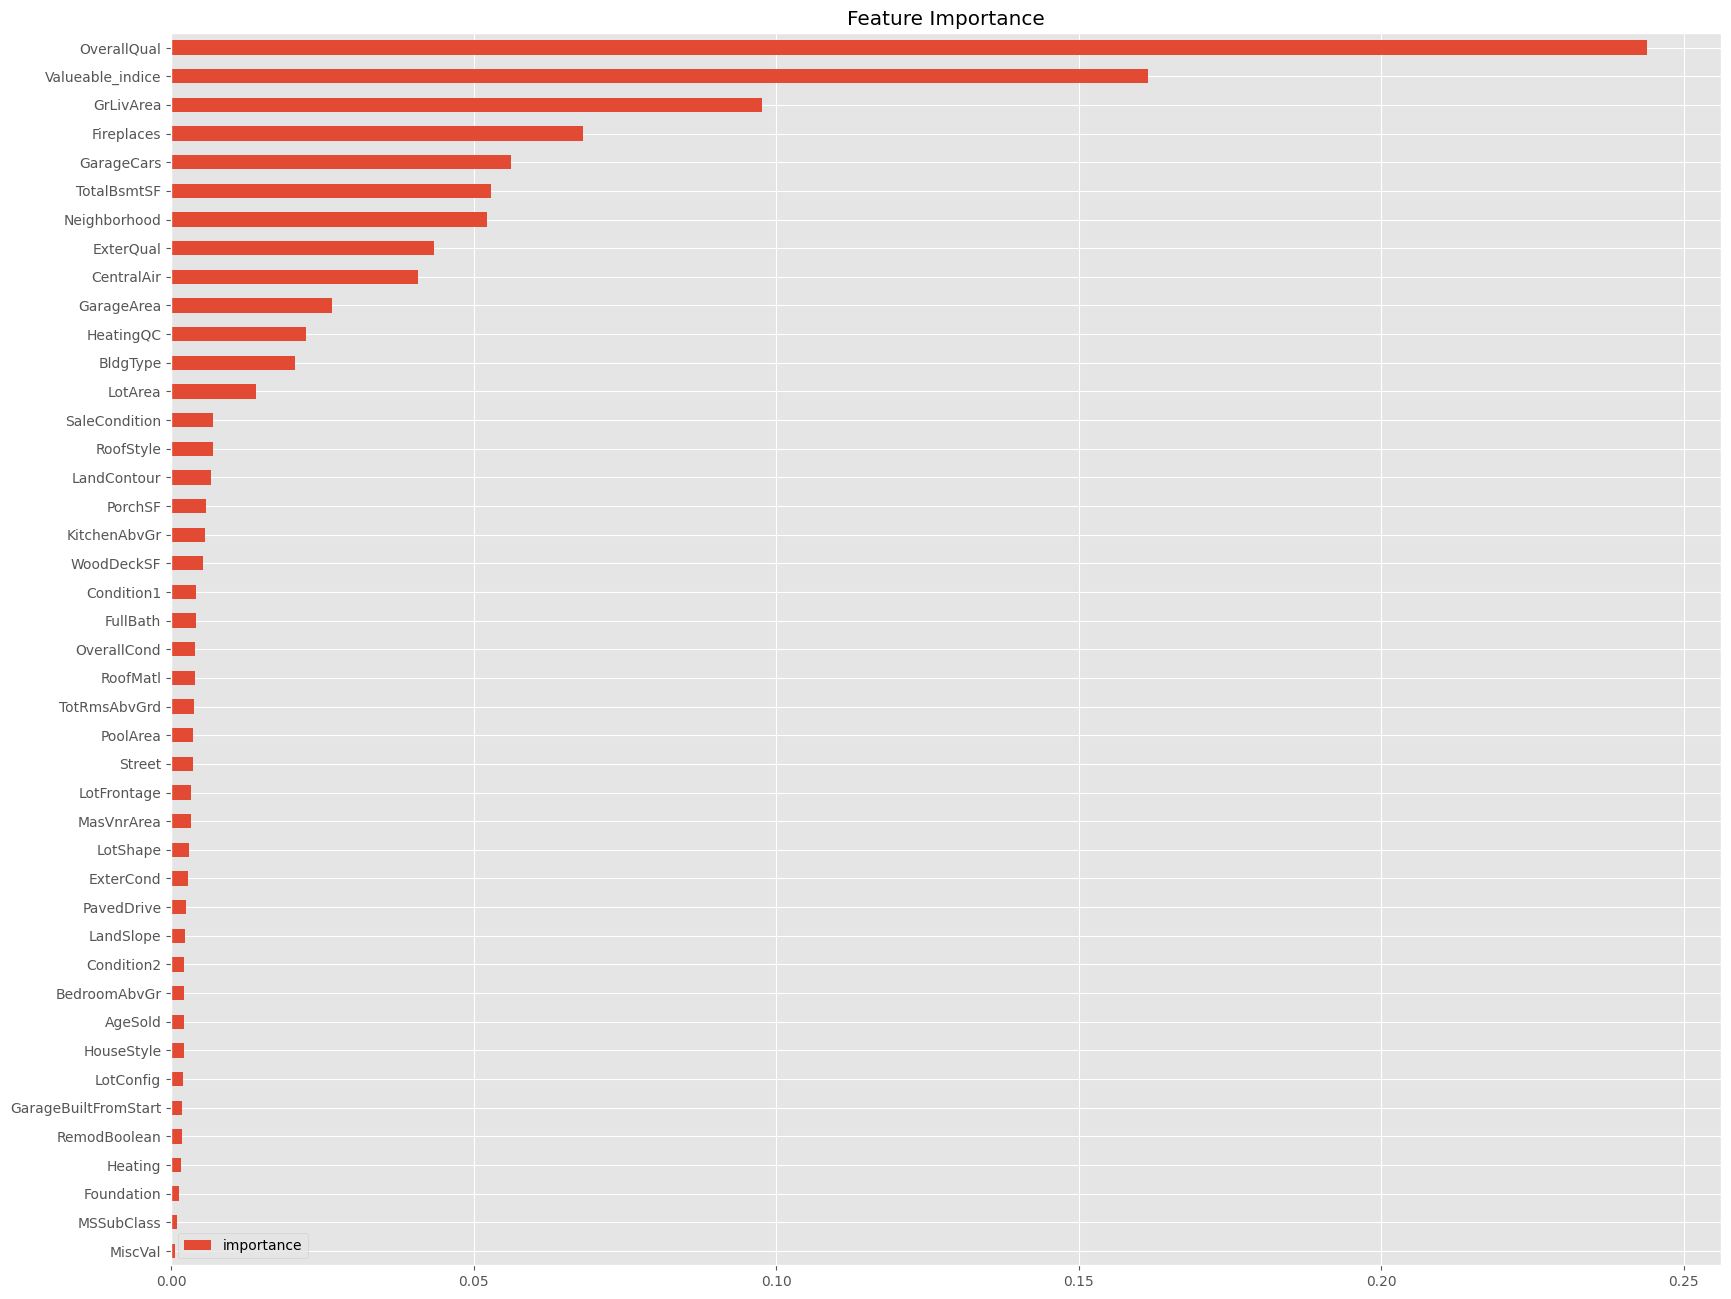

In [56]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(20, 16))
plt.show()

# SVM Regressor model


In [57]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler  # It's often beneficial to scale data for SVMs
from sklearn.pipeline import make_pipeline

# 1. Scaling the Data (Important for SVM)
# SVMs are sensitive to the scale of the features. StandardScaler is commonly used.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use the same scaler fitted on training data

# Using the Pipeline for scaling and SVR 
svr_pipeline = make_pipeline(SVR(kernel='rbf',  C=1, epsilon=0.1))
svr_pipeline.fit(X_train, y_train)

# Predict on training data
y_pred_train = svr_pipeline.predict(X_train)

# Predict on testing data
y_pred_test = svr_pipeline.predict(X_test)

# Calculate RMSE for training data
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

# Calculate RMSE for testing data
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Print the RMSE values
print(f"RMSE of SVR Model on Training Data: {rmse_train}")
print(f"RMSE of SVR Model on Testing Data:  {rmse_test}")



RMSE of SVR Model on Training Data: 0.1816783676533161
RMSE of SVR Model on Testing Data:  0.20493942885661195


# LGBM

In [58]:
# 9. LightGBM
lgb_model = lgb.LGBMRegressor(num_leaves=3,
                              learning_rate=0.06, 
                              n_estimators=1000,
                              reg_alpha = 0, 
                              reg_lambda=0)
evaluate_model(lgb_model, X_train, y_train, X_test, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1951
[LightGBM] [Info] Number of data points in the train set: 876, number of used features: 38
[LightGBM] [Info] Start training from score 12.036873
Model: LGBMRegressor
Train RMSE: 0.07879264189739942
Test RMSE: 0.14044647994729964
--------------------


(0.07879264189739942, 0.14044647994729964)

In [ ]:
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")


def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return rmse

# Optimize hyperparameters
study = optuna.create_study(direction='minimize')  # Minimize RMSE
study.optimize(objective, n_trials=100)  # Adjust n_trials as needed



In [61]:
# Get best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train model with best hyperparameters
best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X, y)

# Evaluate on training and test sets
train_predictions = best_model.predict(X)
# test_predictions = best_model.predict(X_test)

train_rmse = mean_squared_error(y, train_predictions, squared=False)
# test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

print("Training RMSE:", train_rmse)
# print("Test RMSE:", test_rmse)

Best hyperparameters: {'num_leaves': 233, 'learning_rate': 0.011970792323721984, 'n_estimators': 1195, 'reg_alpha': 7.805364151400375e-06, 'reg_lambda': 3.6129881859159503}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 40
[LightGBM] [Info] Start training from score 12.024051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

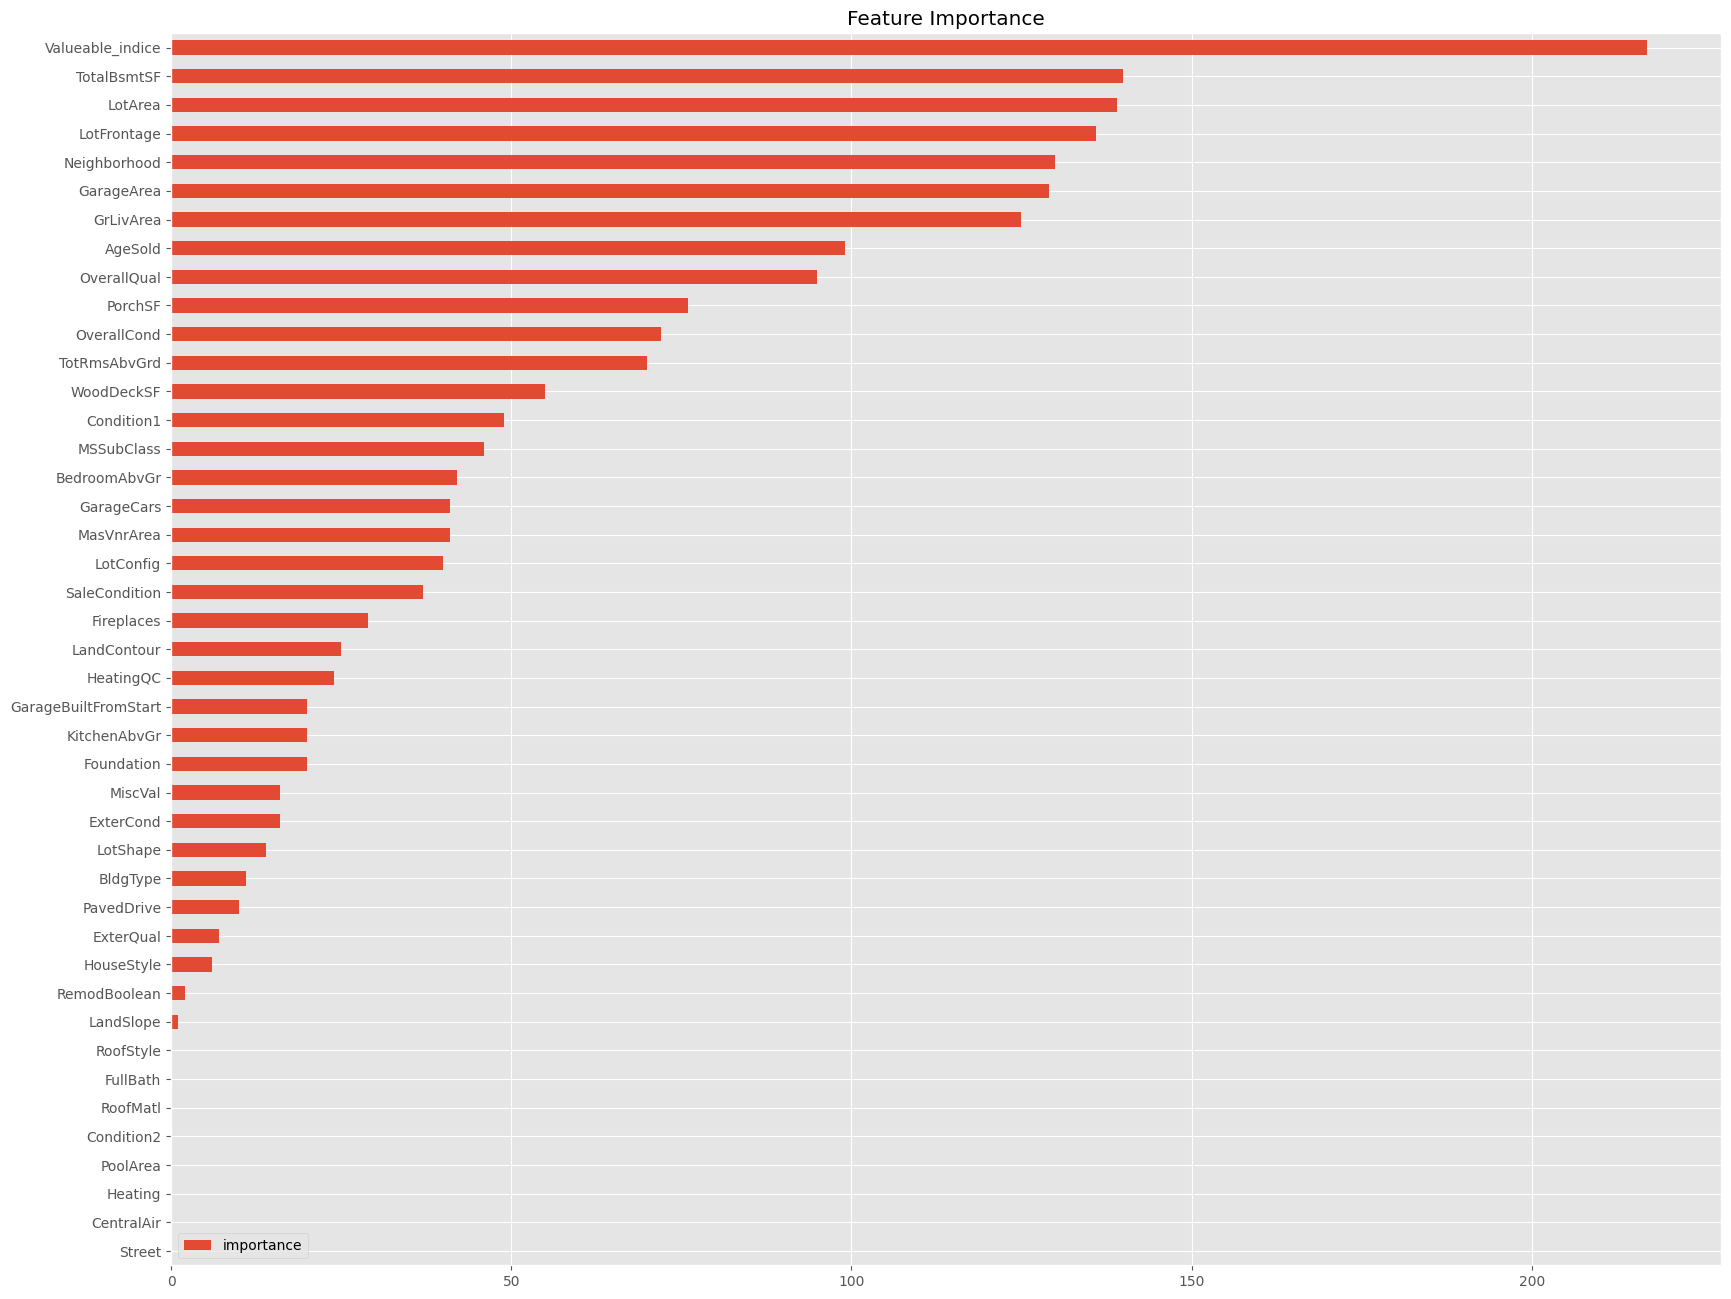

In [103]:
fi = pd.DataFrame(data=lgb_model.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(20, 16))
plt.show()

In [104]:
threshold = 25
low_importance_features = fi[fi['importance'] < threshold].index
low_importance_features

Index(['FullBath', 'KitchenAbvGr', 'PoolArea', 'MiscVal', 'RemodBoolean',
       'GarageBuiltFromStart', 'Street', 'LotShape', 'LandSlope', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual',
       'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir',
       'PavedDrive'],
      dtype='object')

# Neural Networks

In [70]:
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score
import numpy as np  # Add import for numpy

# Assuming you have your data loaded as X and y
# X: features, y: target variable

def objective(trial):
    """Objective function for Optuna optimization."""

    # Define hyperparameters to be tuned
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),  # Range of max_depth
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True), # Log scale for learning_rate
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True), 
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1500),
        'objective': 'reg:linear',  # You can also make this a choice if you want to try different objectives
        'booster': 'gbtree',
        'base_score': 0 # You can also make base_score a tuned parameter if desired
    }

    # Create and train the XGBoost model
    model = xgb.XGBRegressor(**params)

    # Evaluate the model using cross-validation (RMSE as the metric)
    rmse = np.mean(np.abs(cross_val_score(model, X, y, cv=3, scoring='neg_root_mean_squared_error'))) 
    
    return rmse  # Optuna minimizes the objective value

# Create a study object
study = optuna.create_study(direction='minimize')  # We want to minimize RMSE

# Start the optimization
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the final model with the best hyperparameters
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X, y) 

e:\ML Projects\Kaggle\House Prices\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-12-04 11:01:58,253] A new study created in memory with name: no-name-5b713964-56e3-4463-b6f0-f9a64e2ce907
e:\ML Projects\Kaggle\House Prices\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:01:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
e:\ML Projects\Kaggle\House Prices\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:01:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227

Best Hyperparameters: {'max_depth': 3, 'learning_rate': 0.020929375896741147, 'reg_alpha': 2.0931515680881494e-05, 'reg_lambda': 3.4936956923975877e-06, 'n_estimators': 782}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.020929375896741147,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=782, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [110]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers

# 1. Model Architecture
model = models.Sequential([
    layers.Dense(1024, activation='relu', input_shape=(X.shape[1],)),
    #layers.BatchNormalization(), 

    layers.Dense(512, activation='relu'),
    #layers.BatchNormalization(),

    #layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    #layers.BatchNormalization(),

    #layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    #layers.BatchNormalization(),

    #layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    #layers.BatchNormalization(),
    layers.Dense(1) # Output layer
])




# 1. Define the learning rate schedule function
def lr_schedule(epoch):
    if epoch < 50:
        return 1e-4
    elif epoch < 100:
        return 5e-5
    elif epoch < 150:
        return 1e-5
    else:
        return 3e-6

# 2. Create the LearningRateScheduler callback
lr_scheduler = callbacks.LearningRateScheduler(lr_schedule)

# 3. Compile the Model (keep your existing optimizer settings)
optimizer = tf.keras.optimizers.Adam()  # Note: initial learning rate is handled by the scheduler
model.compile(optimizer=optimizer, 
              loss='mean_squared_error',  
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]) 

# # 4. Early Stopping
# early_stopping = callbacks.EarlyStopping(
#     monitor='val_rmse',  
#     patience=50,          
#     restore_best_weights=True 
# )

# 5. Train the Model (add the lr_scheduler to your callbacks)
history = model.fit(X, y, 
                    epochs=200,  # You can increase this
                    batch_size=4, 
                    # validation_data=(X_test, y_test), 
                    callbacks=[#early_stopping, 
                               lr_scheduler])  # Include the learning rate scheduler

# 6. Evaluate the Model
#rmse = model.evaluate(X_test, y_test)[1]  
#print(f"RMSE on Test Data: {rmse}") 

Epoch 1/200


e:\ML Projects\Kaggle\House Prices\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.3729 - rmse: 2.1386 - learning_rate: 1.0000e-04
Epoch 2/200
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0626 - rmse: 0.2488 - learning_rate: 1.0000e-04
Epoch 3/200
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1098 - rmse: 0.3294 - learning_rate: 1.0000e-04
Epoch 4/200
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1070 - rmse: 0.3243 - learning_rate: 1.0000e-04
Epoch 5/200
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0664 - rmse: 0.2571 - learning_rate: 1.0000e-04
Epoch 6/200
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1293 - rmse: 0.3534 - learning_rate: 1.0000e-04
Epoch 7/200
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0697 - rmse: 0.2629 - learning_rate: 1.0000e-04
Epoch 8/200
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0694 - rmse: 0.2632 - learning_rate: 1.0000e-04
Epoch 9/200
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0561 - rmse: 0.2364 - learning_rate: 1.0000e-04
Epoch 10/200


# Submission creation

In [709]:
# reg = xgb.XGBRegressor(base_score=0.5, 
#                        booster='gbtree',    
#                        n_estimators=1000,
                       
#                        objective='reg:linear',
#                        max_depth=1,
#                        learning_rate=0.01)

# reg.fit(X, y)

linear_model.fit(X, y)
lgb_model.fit(X,y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2350
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 82
[LightGBM] [Info] Start training from score 12.024051


LGBMRegressor(n_estimators=1000, num_leaves=22)

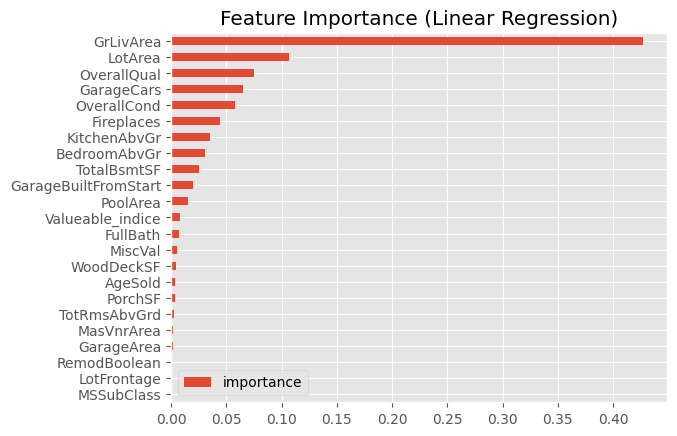

In [116]:
# 2. Get the coefficients (feature weights)
coefficients = linear_model.coef_ 

# 3. Create a DataFrame with feature names and their absolute coefficients
fi = pd.DataFrame(data=abs(coefficients),  # Use absolute values for magnitude
                  index=reg.feature_names_in_, 
                  columns=['importance'])

# 4. Sort and plot
fi.sort_values('importance').plot(kind='barh', title='Feature Importance (Linear Regression)')
plt.show()

In [62]:
y_pred_raw = best_model.predict(merged_df_test)

# 1. Load the sample submission CSV into a Pandas DataFrame
submission_df = pd.read_csv('sample_submission.csv')

# 2. Assuming y_pred_final is your prediction array/list/Series
#    Replace the 'SalePrice' column with your predictions 
submission_df['SalePrice'] = np.exp(y_pred_raw)

# 3. Save the updated DataFrame back to a CSV file (you can choose a new name)
submission_df.to_csv('my_submission.csv', index=False)  # index=False to avoid writing row indices